In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/samuelcortinhas/time-series-practice-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: donkeysally
Your Kaggle Key: ··········


100%|██████████| 910k/910k [00:00<00:00, 41.6MB/s]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# 1. EDA

In [5]:
train = pd.read_csv('/content/time-series-practice-dataset/train.csv')
test = pd.read_csv('/content/time-series-practice-dataset/test.csv')

In [6]:
train.head()

,Date,store,product,number_sold
0,2010-01-01,0,0,801
1,2010-01-02,0,0,810
2,2010-01-03,0,0,818
3,2010-01-04,0,0,796
4,2010-01-05,0,0,808


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230090 entries, 0 to 230089
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date         230090 non-null  object
 1   store        230090 non-null  int64 
 2   product      230090 non-null  int64 
 3   number_sold  230090 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.0+ MB


In [8]:
train[['store', 'product']].nunique()

store       7
product    10
dtype: int64

In [9]:
store = list(train.store.unique())

In [10]:
product = list(train['product'].unique())

In [11]:
# Visualize sale of each store according to the product type
def storesell(df, type):
  plt.figure(figsize = (45,100))
  for i, st in enumerate(store):
      axes = plt.subplot(15, 5, i+1)
      df.query(f'store == {st} & product == {type}')['number_sold'].plot()
      plt.title(f'store {st} product {type} sold')
      plt.ylabel('number_sold')
plt.show()

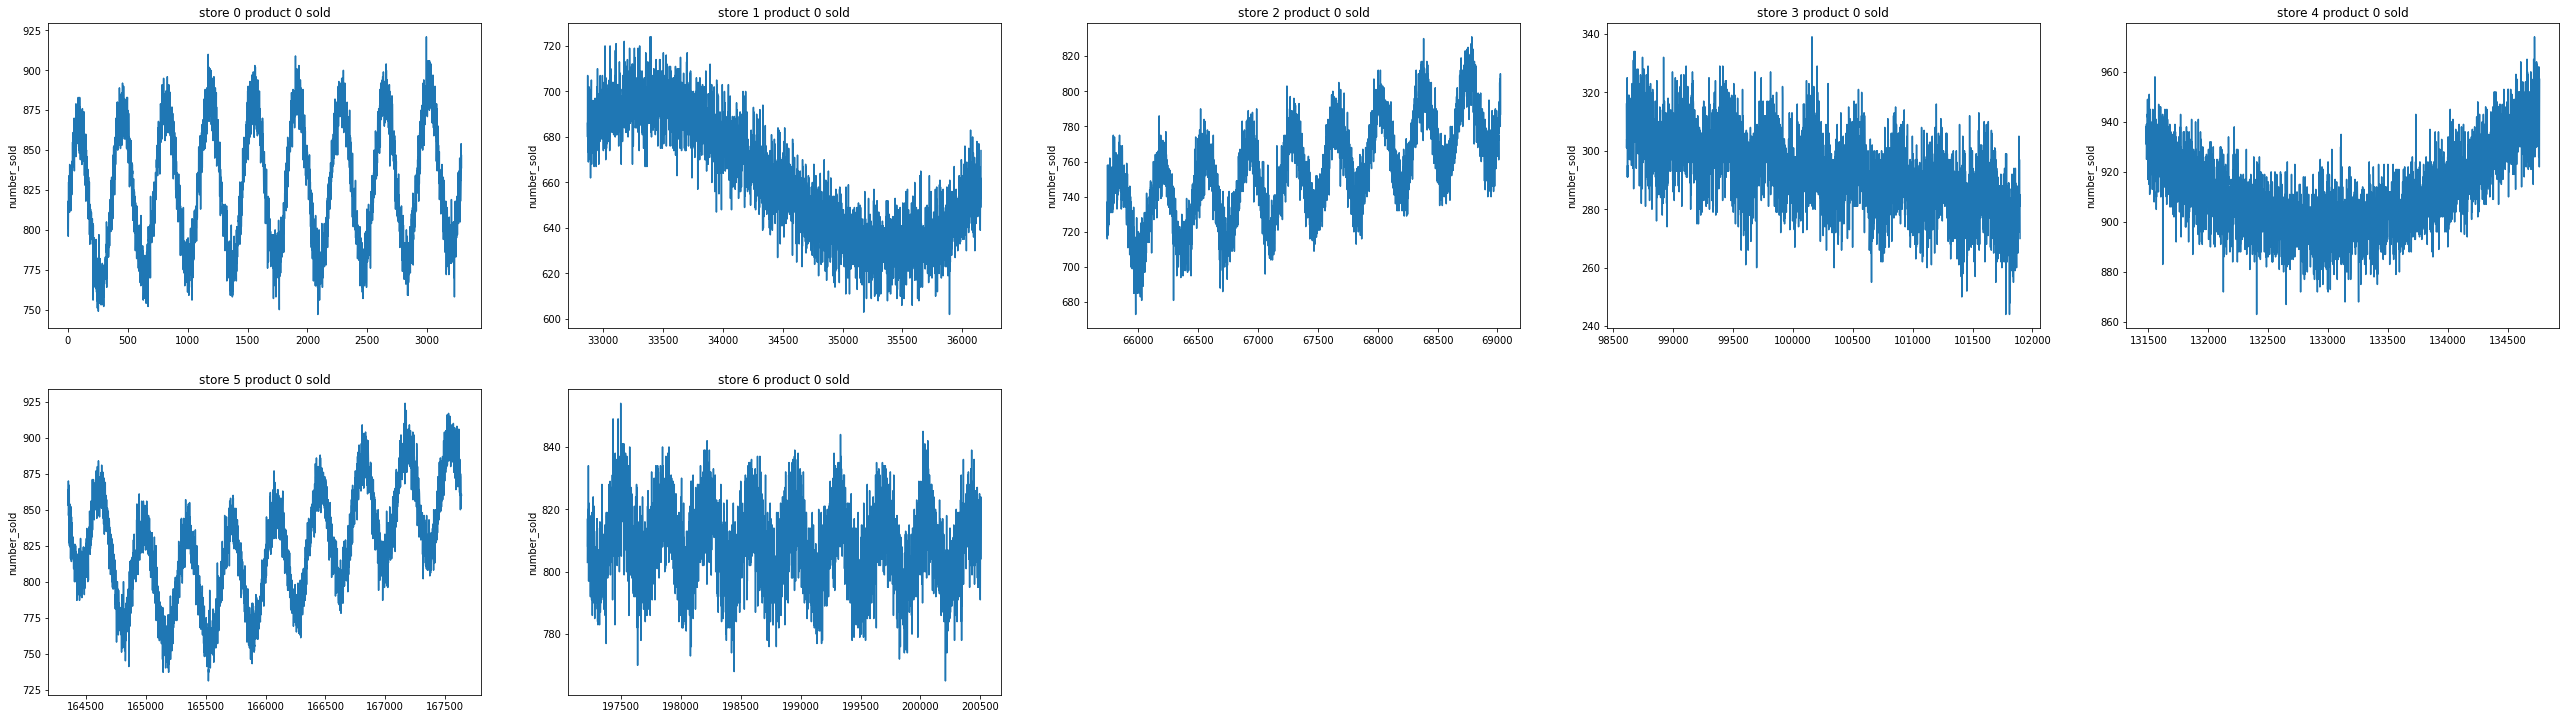

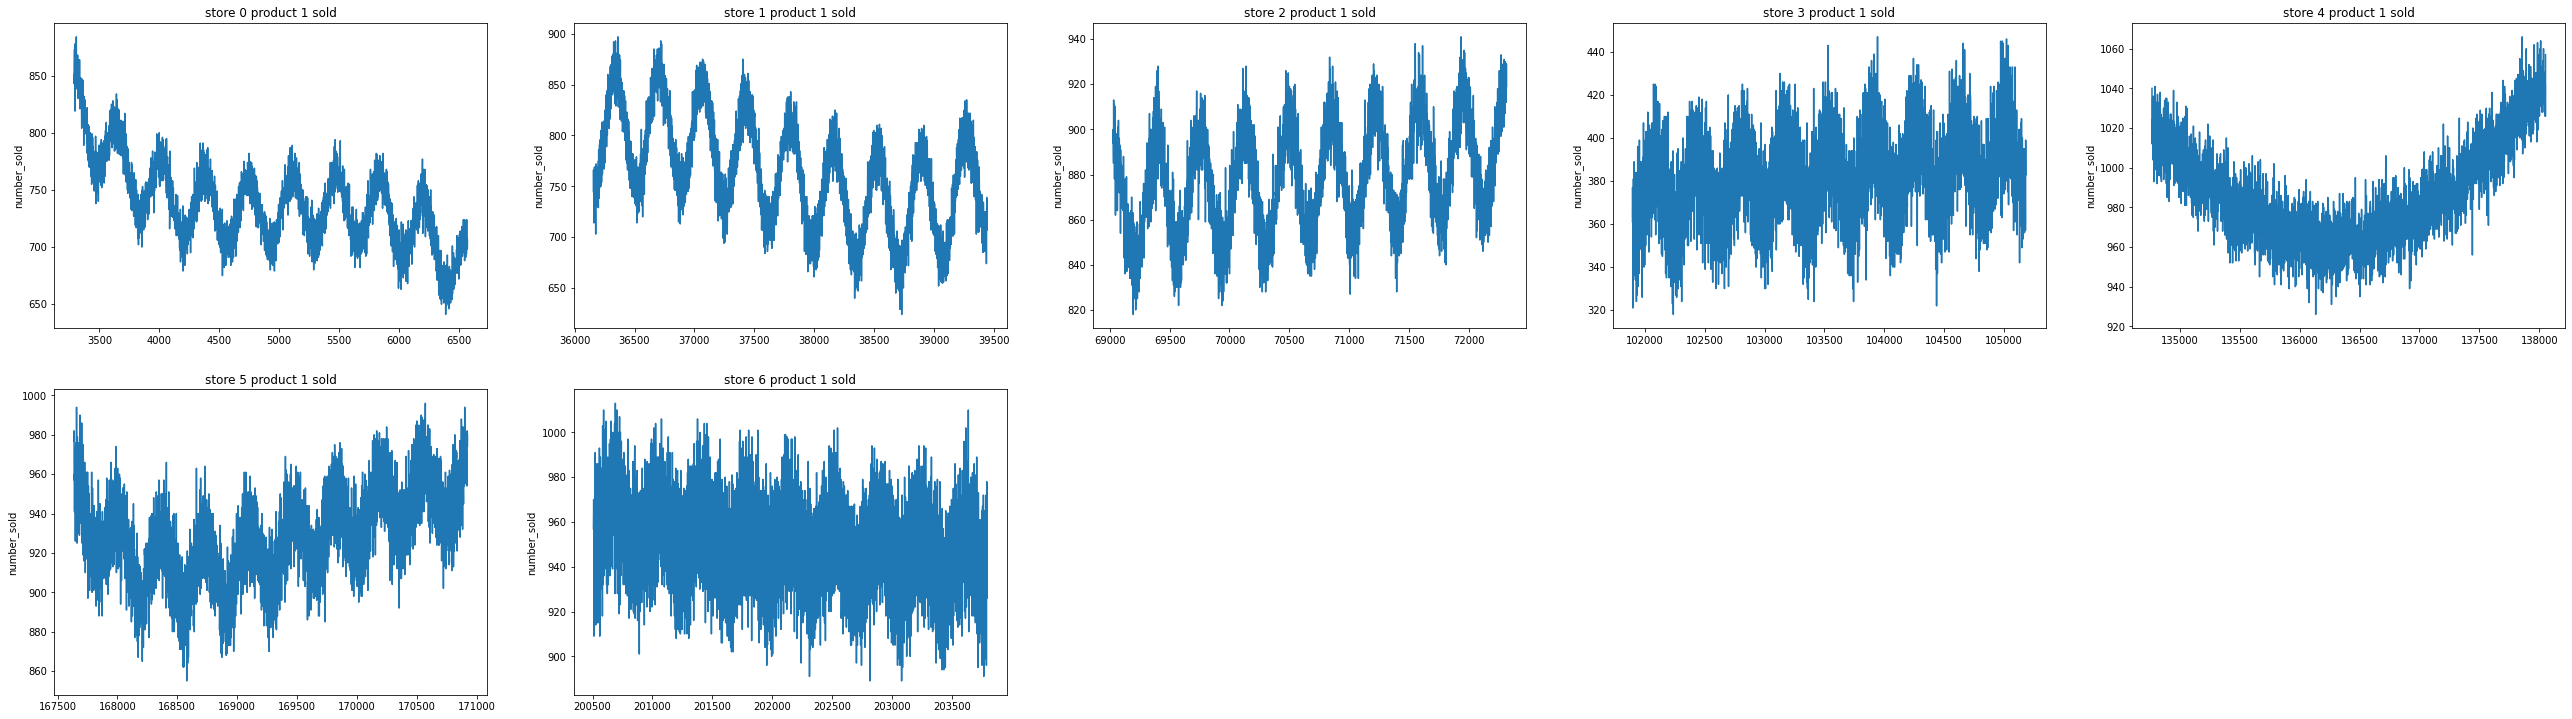

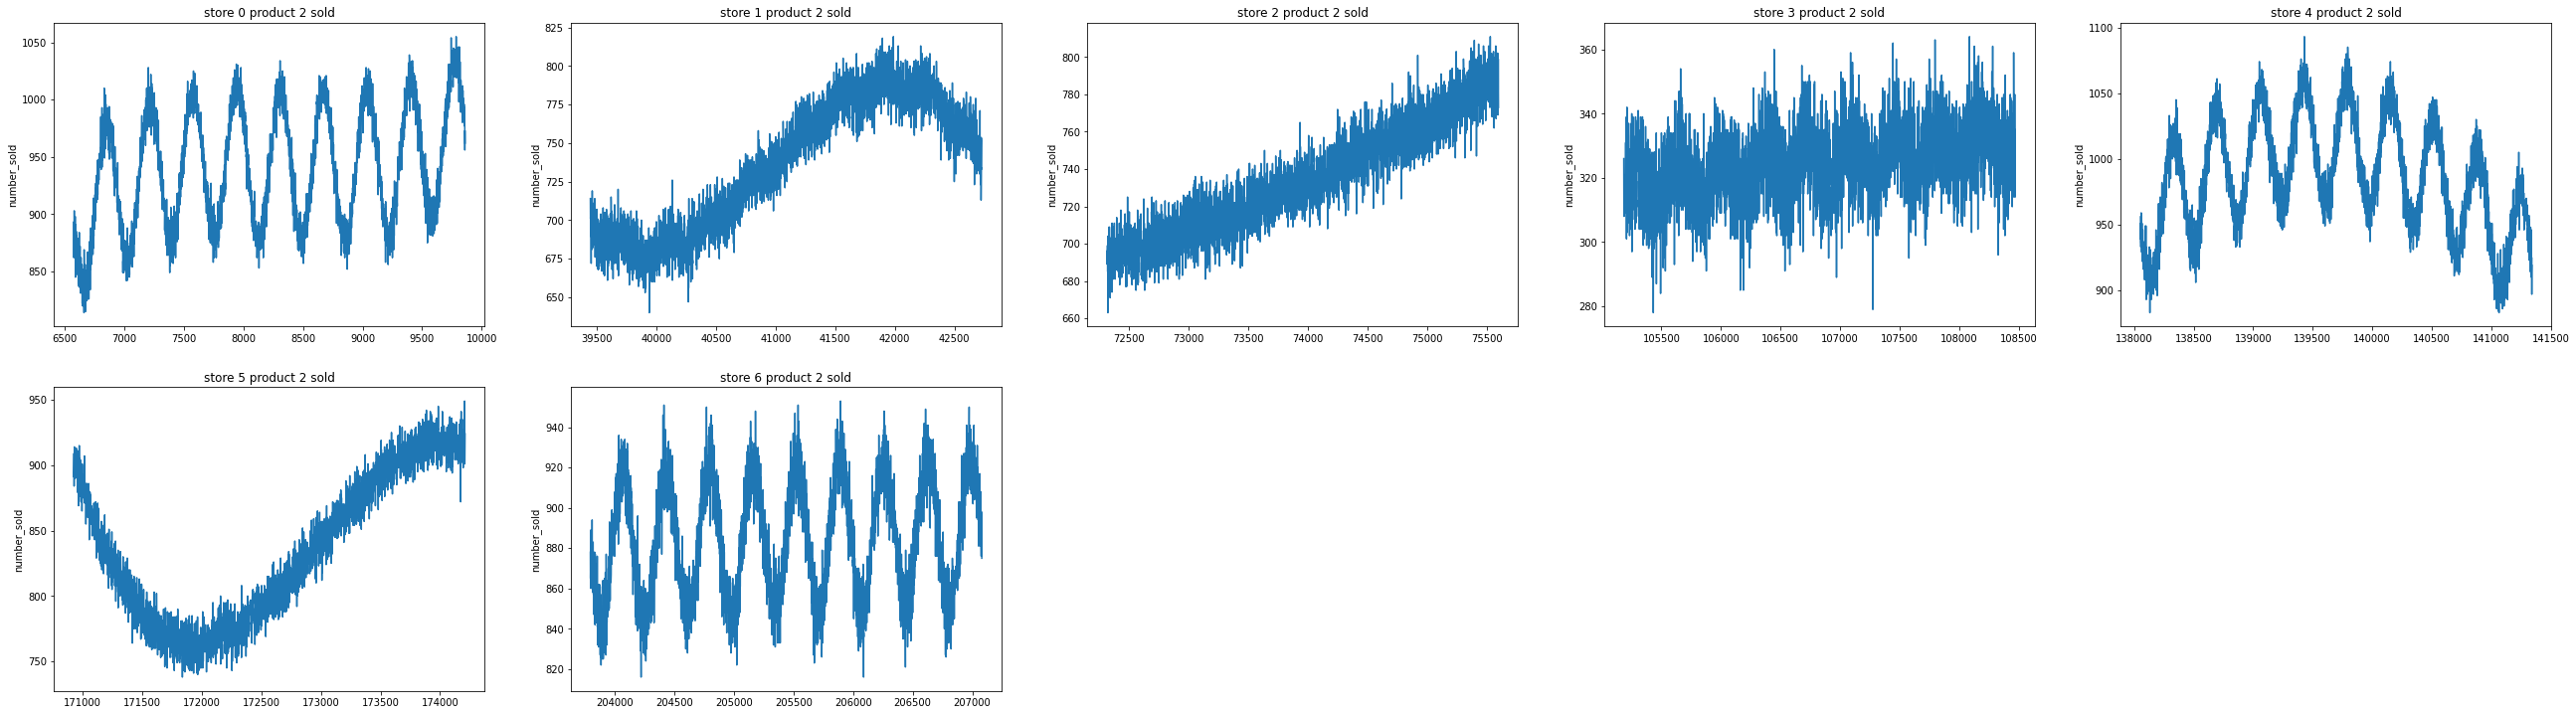

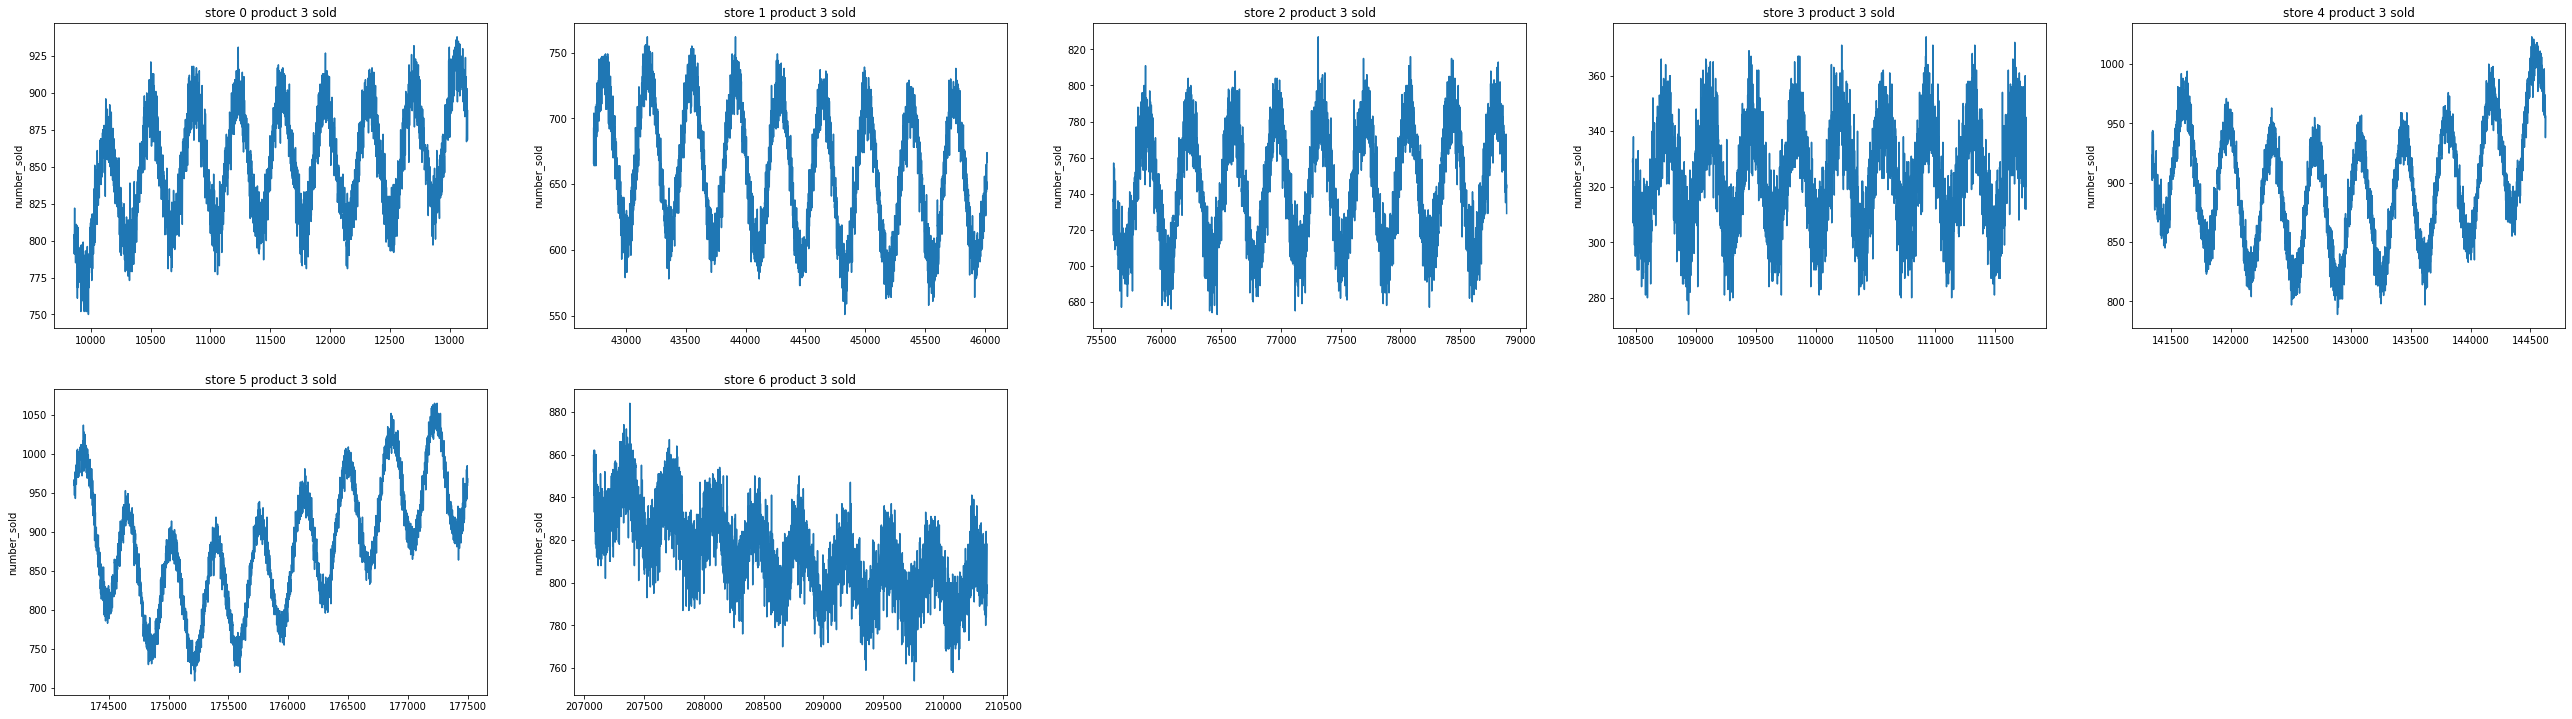

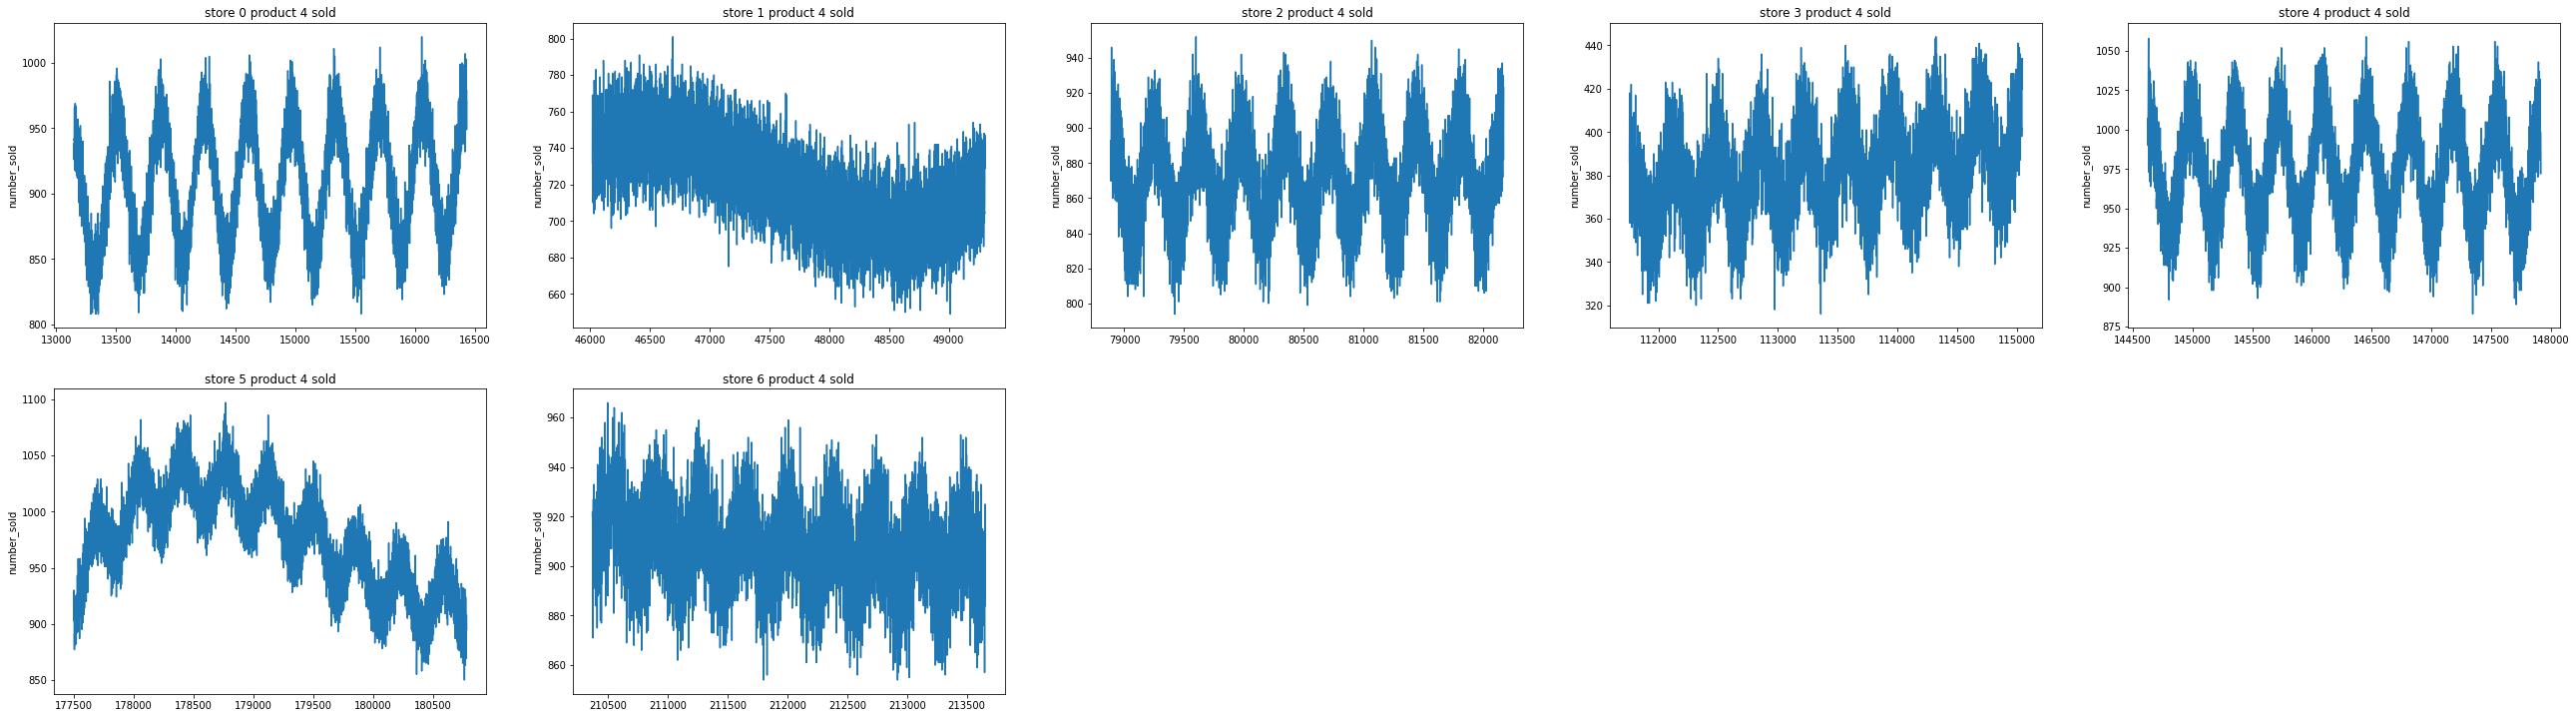

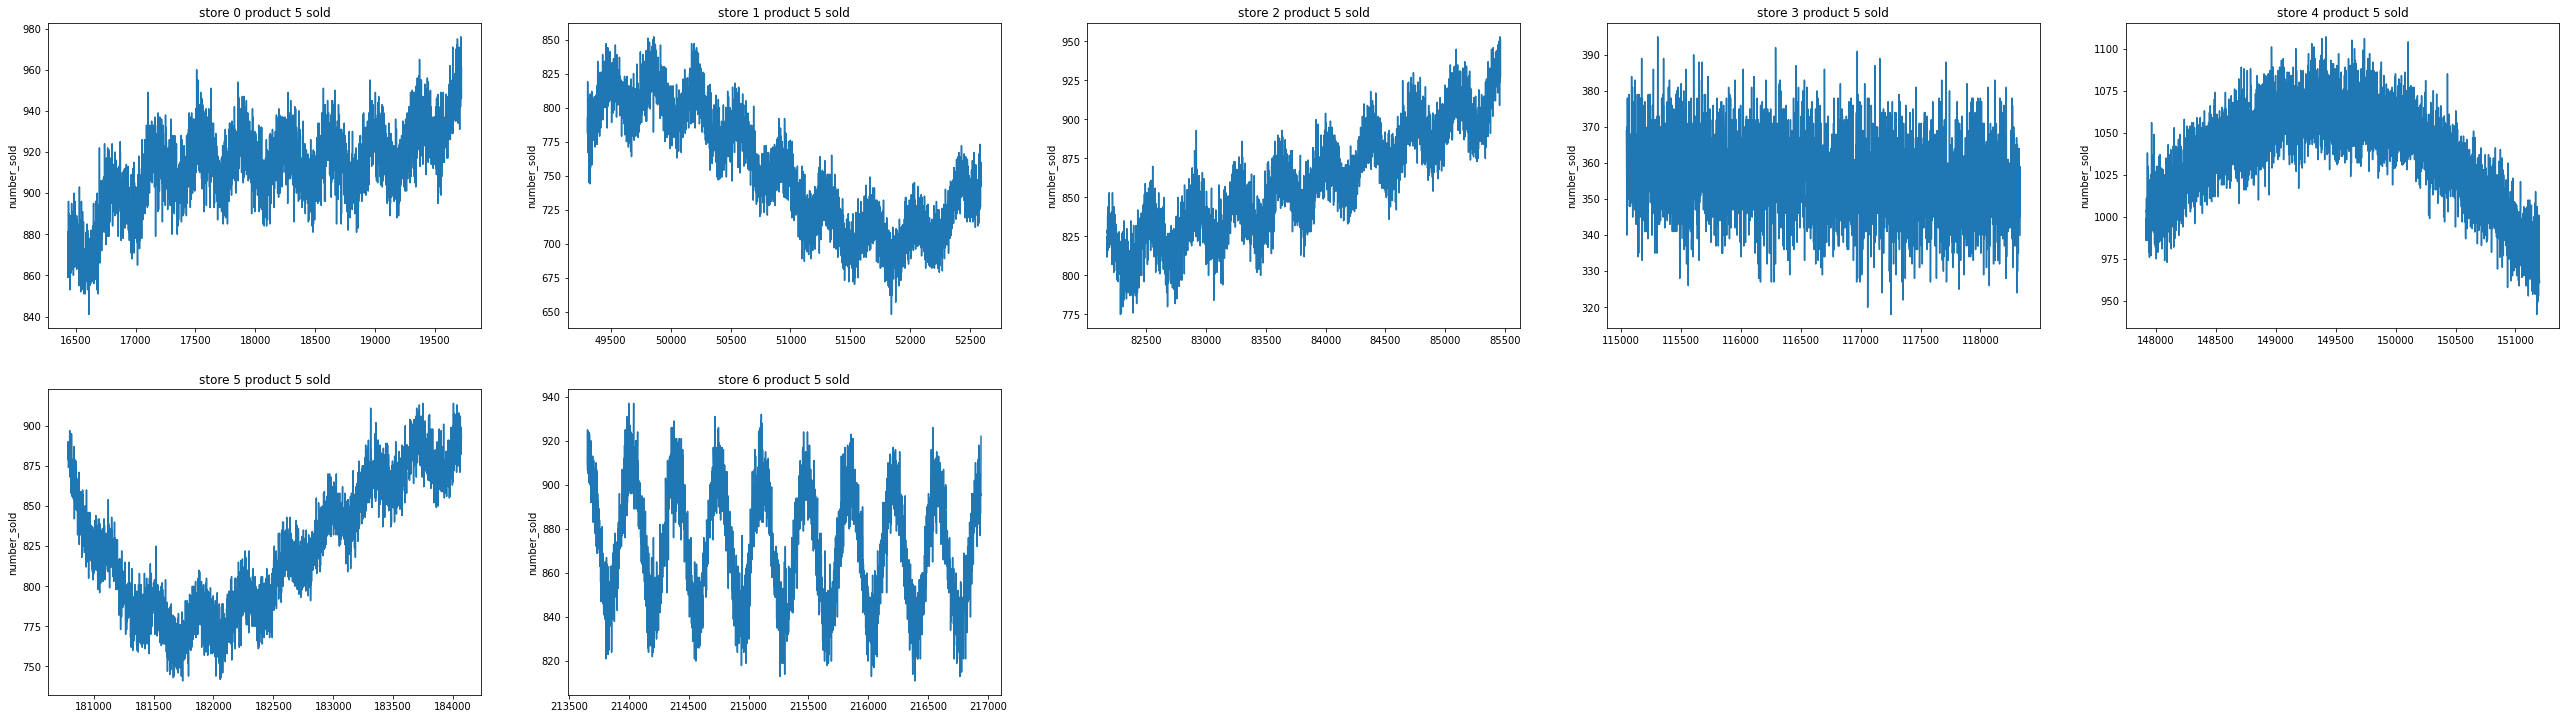

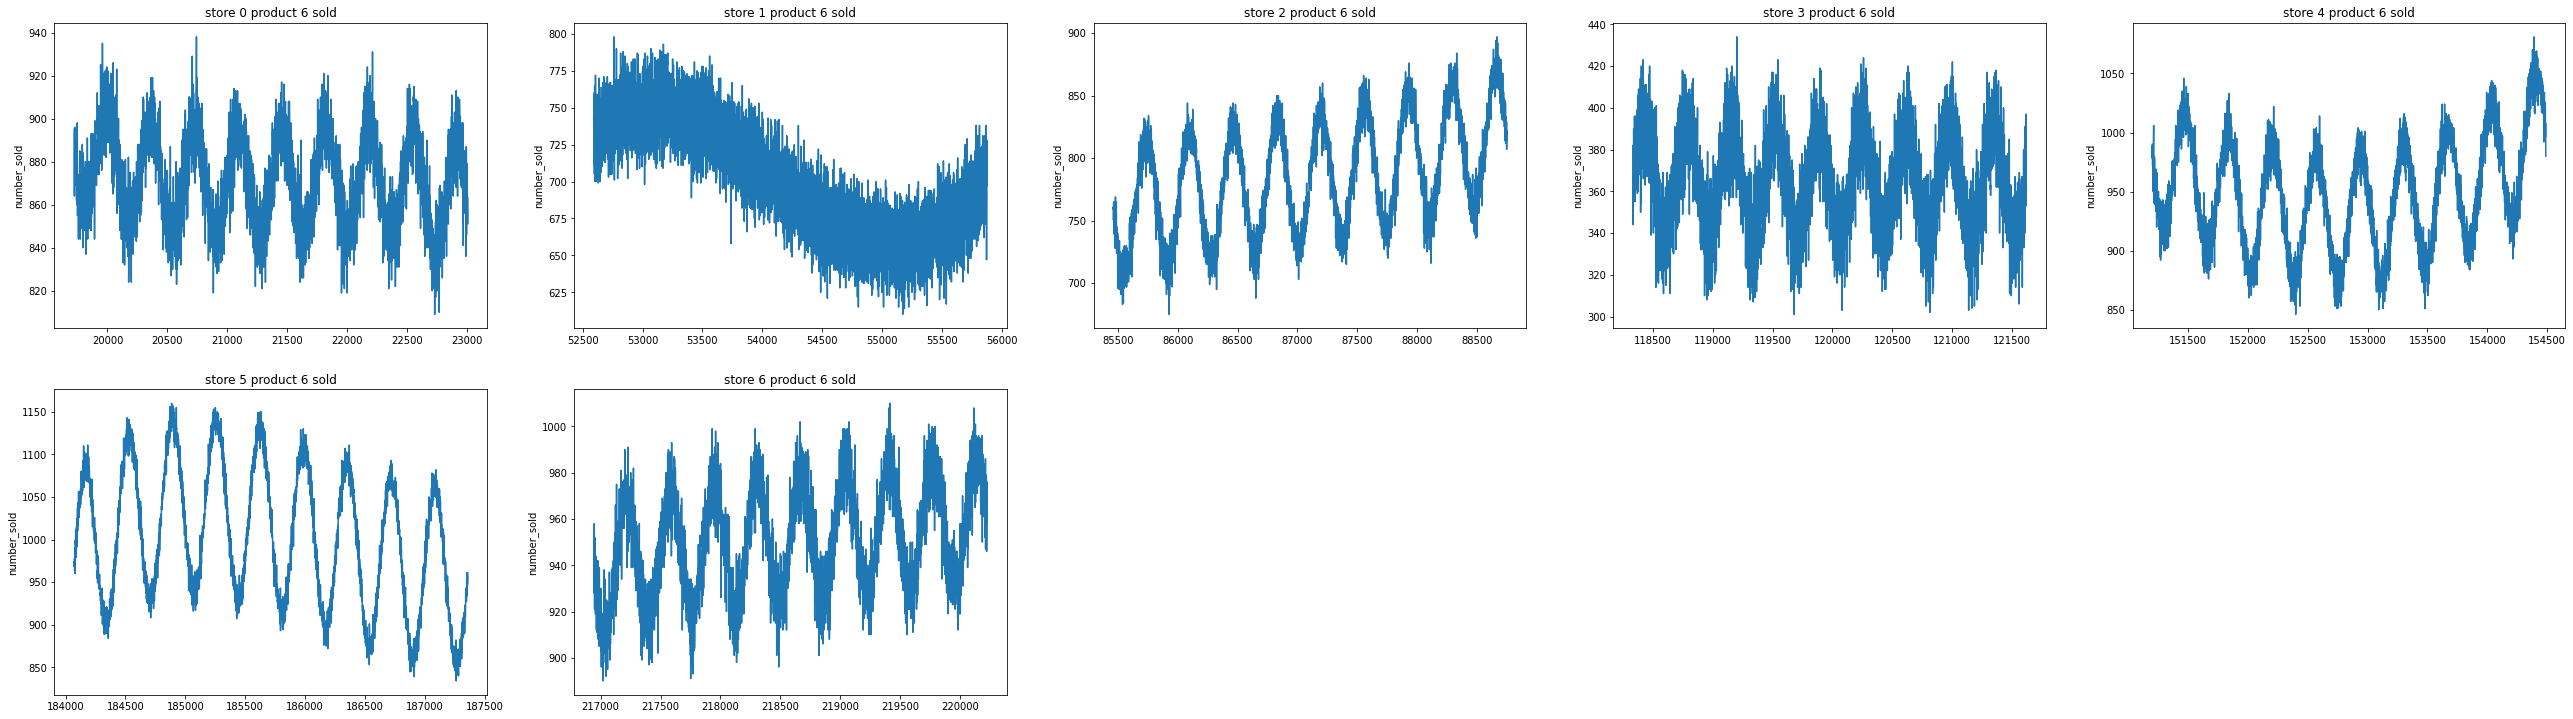

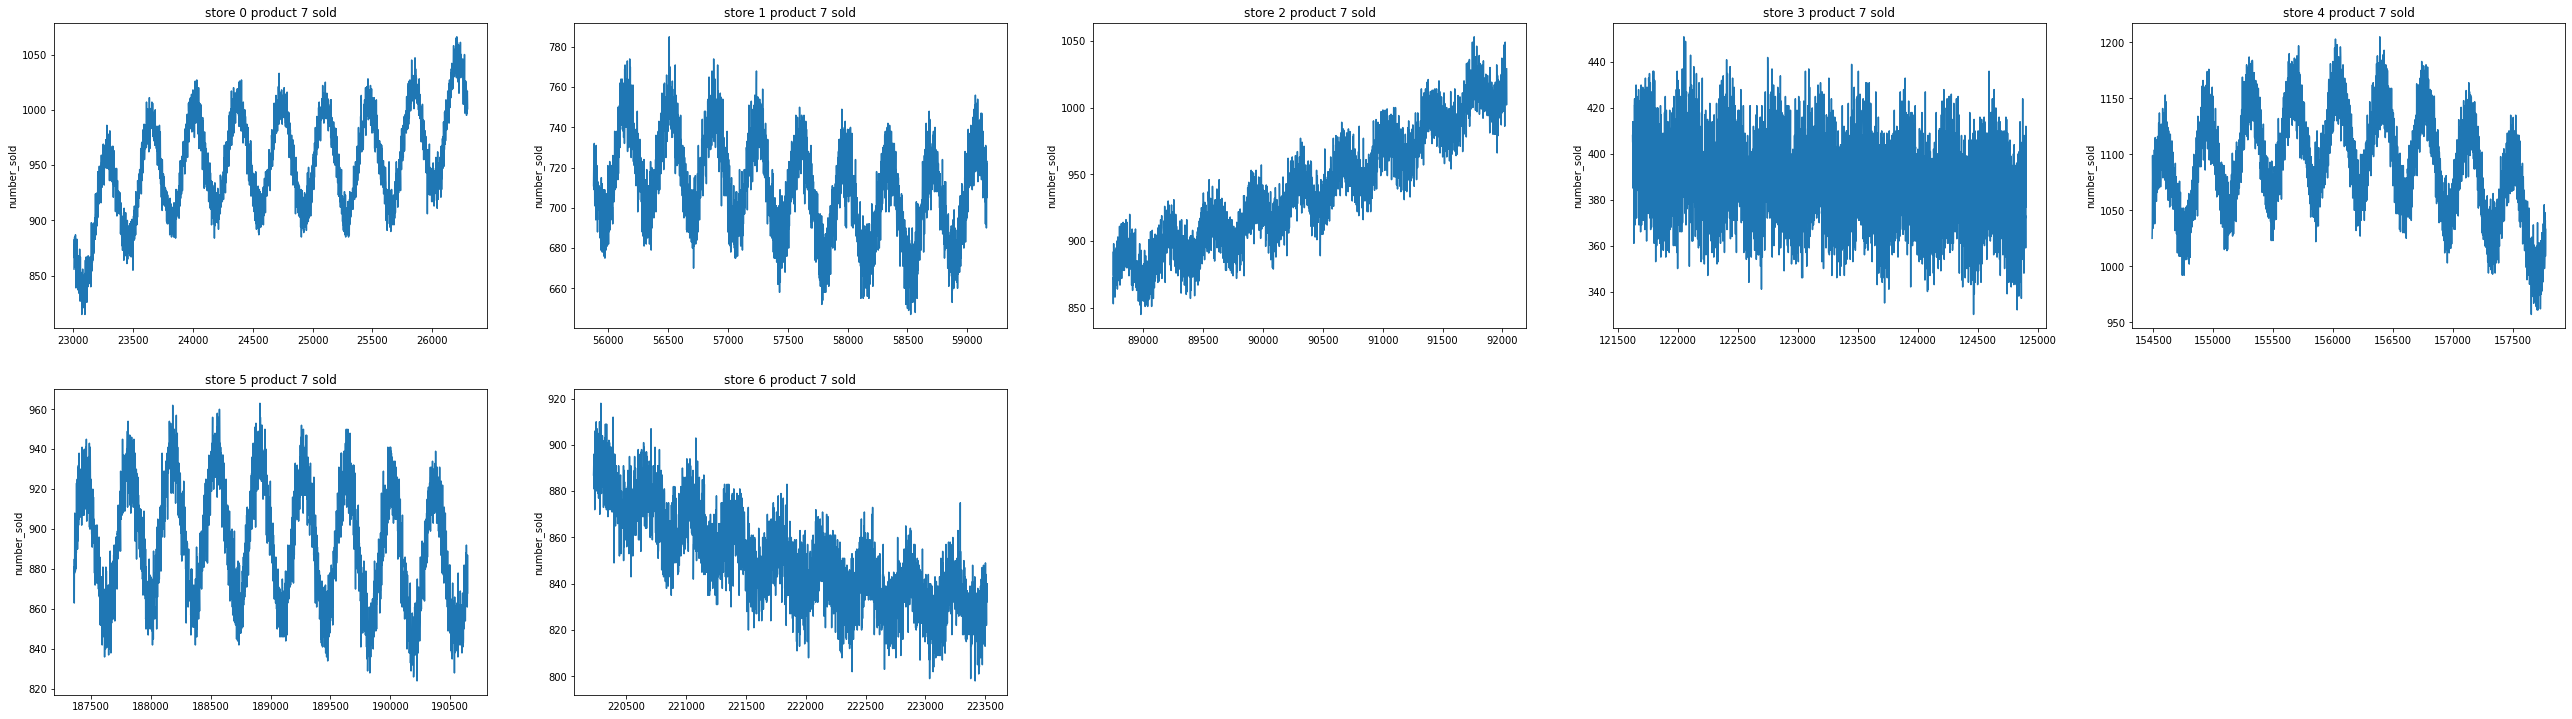

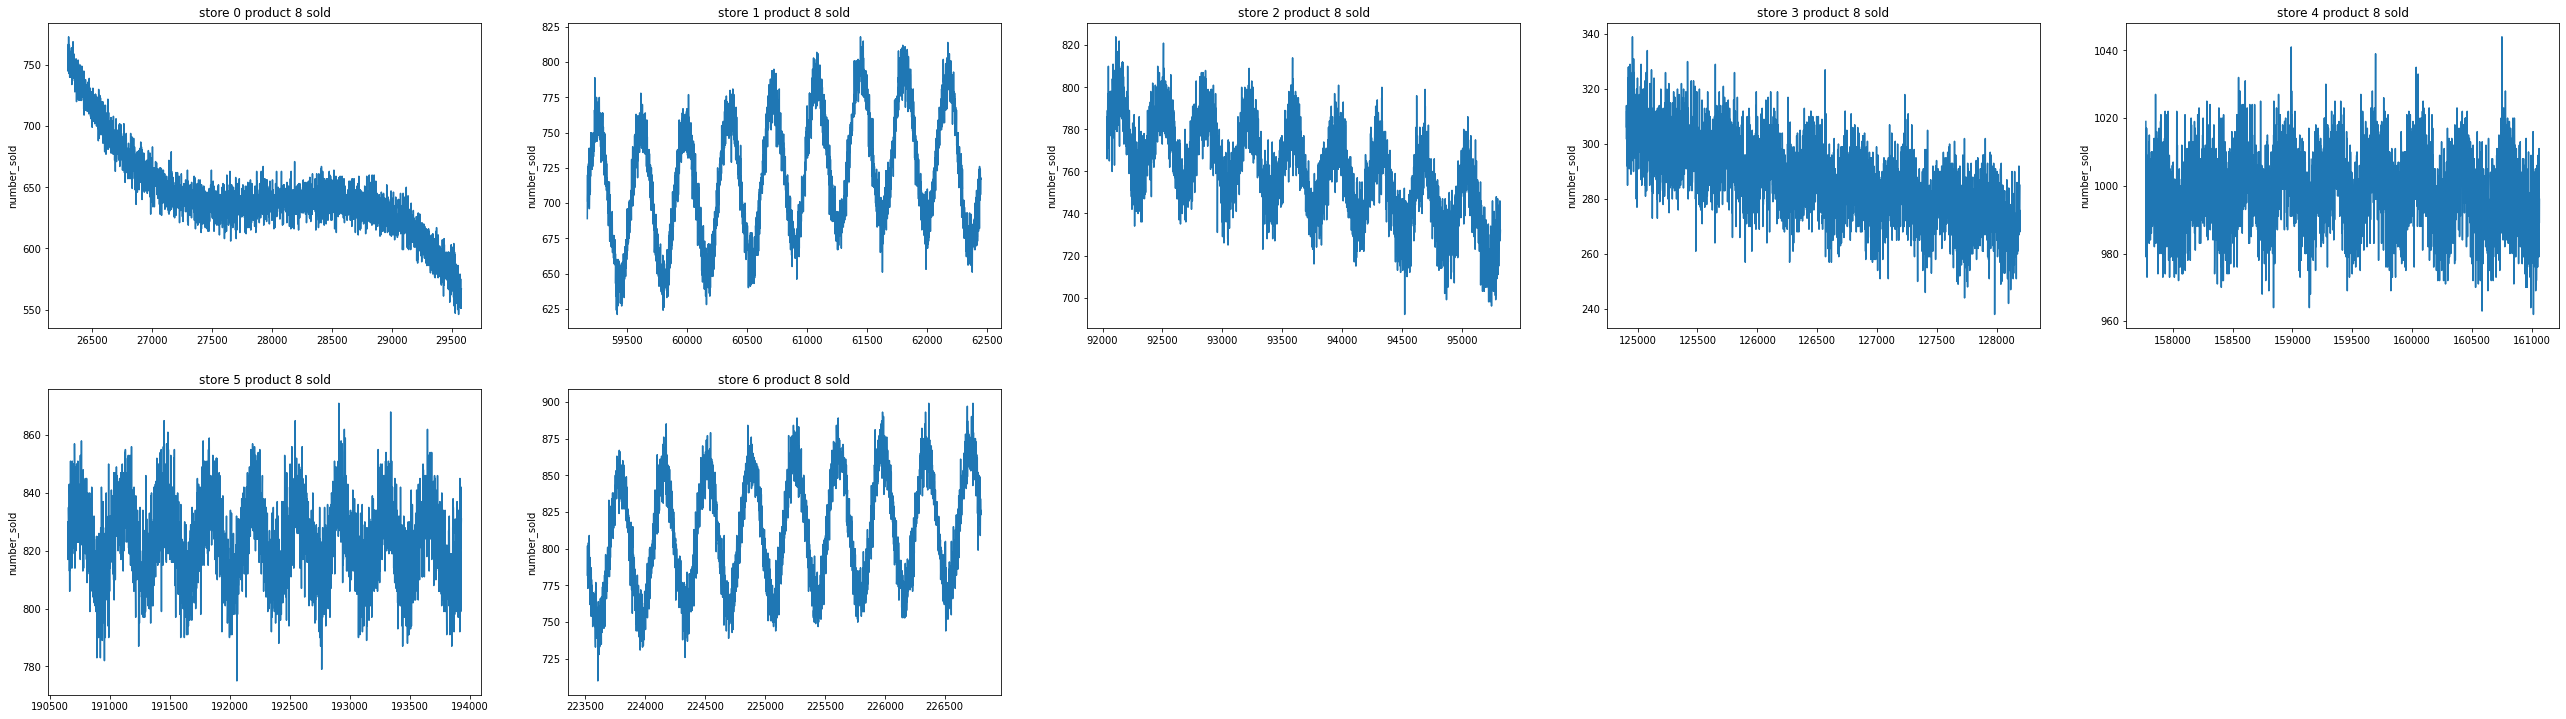

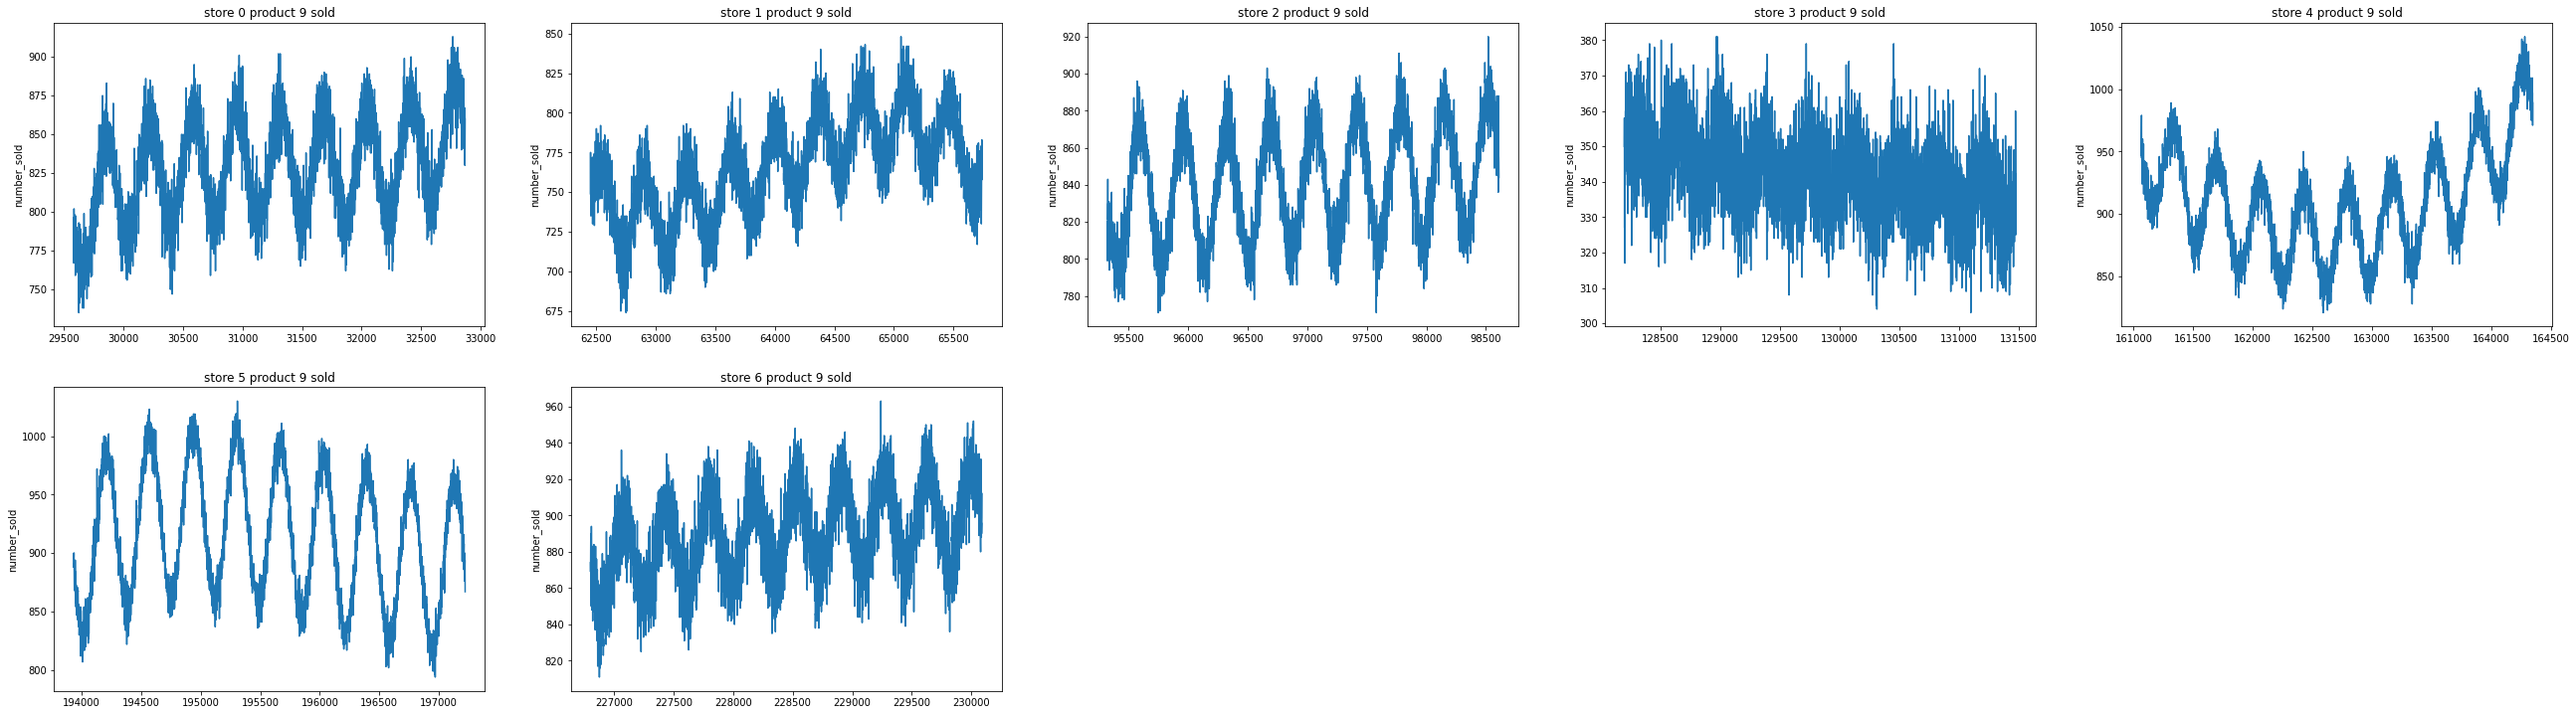

In [12]:
for i in product:
  storesell(train, i)

#2. Data preprocessing

In [13]:
# Make date to index for time series analysis
train = train.set_index('Date')
train.index = pd.to_datetime(train.index)

In [14]:
#Function for time feature creation
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

In [15]:
df = create_features(train)

Index(['store', 'product', 'number_sold', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth'],
      dtype='object')

In [16]:
# train test(validation) split
train2 = train.loc[:'2017-01-01'].copy()
valid = train.loc['2017-01-01':].copy()

In [17]:
train2 = create_features(train2)
valid =  create_features(valid)

In [19]:
FEATURES = ['store', 'product', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'dayofmonth']
TARGET = 'number_sold'

#3. Modelling

In [20]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [21]:
X_train = train2[FEATURES]
y_train = train2[TARGET]

X_test = valid[FEATURES]
y_test = valid[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                      n_estimators=1000,
                      objective='reg:linear',
                      learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

y_pred = reg.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE Score on Test set: {score:0.2f}')

[05:56:57] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:797.29027	validation_1-rmse:803.38844
[100]	validation_0-rmse:294.50756	validation_1-rmse:301.15169
[200]	validation_0-rmse:112.85452	validation_1-rmse:120.81596
[300]	validation_0-rmse:50.16413	validation_1-rmse:59.85394
[400]	validation_0-rmse:31.47119	validation_1-rmse:42.21337
[500]	validation_0-rmse:26.45691	validation_1-rmse:37.01428
[600]	validation_0-rmse:24.28435	validation_1-rmse:34.55446
[700]	validation_0-rmse:22.41456	validation_1-rmse:33.00326
[800]	validation_0-rmse:21.33497	validation_1-rmse:31.91226
[900]	validation_0-rmse:19.75762	validation_1-rmse:30.50387
[999]	validation_0-rmse:18.92266	validation_1-rmse:29.74378
RMSE Score on Test set: 29.74


<AxesSubplot:title={'center':'Feature Importance'}>

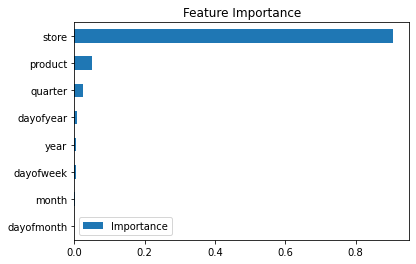

In [22]:
Fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.get_booster().feature_names,
             columns = ['Importance'])

Fi.sort_values('Importance').plot(kind = 'barh', title = 'Feature Importance')

In [23]:
valid['prediction'] = reg.predict(X_test)

In [24]:
valid[['prediction', 'number_sold']] 

,prediction,number_sold
Date,,
2017-01-01,839.669861,850
2017-01-02,841.510559,839
2017-01-03,842.434937,838
2017-01-04,842.434937,835
2017-01-05,842.491882,835
...,...,...
2018-12-27,896.253479,890
2018-12-28,905.000671,892
2018-12-29,907.842285,895


#4. Prediction on test set

In [25]:
test = test.set_index('Date')
test.index = pd.to_datetime(test.index)

In [26]:
# Retrain on all data
all = create_features(train)

X_all = all[FEATURES]
y_all = all[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[05:59:23] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:798.67098
[100]	validation_0-rmse:299.78233
[200]	validation_0-rmse:126.81189
[300]	validation_0-rmse:74.24863
[400]	validation_0-rmse:60.00507
[499]	validation_0-rmse:55.49427


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [27]:
df_copy = train.copy()

In [28]:
# Create future dataframe
test['isFuture'] = True
df_copy['isFuture'] = False
df_and_future = pd.concat([df_copy, test])
df_and_future = create_features(df_and_future)

In [29]:
Future_w_features = df_and_future.query('isFuture').copy()

In [31]:
Future_w_features['pred'] = reg.predict(Future_w_features[FEATURES])

In [34]:
RMSE = np.sqrt(mean_squared_error(Future_w_features['number_sold'], Future_w_features['pred']))
print(f'RMSE Score on Test set: {RMSE:0.2f}')

RMSE Score on Test set: 71.17


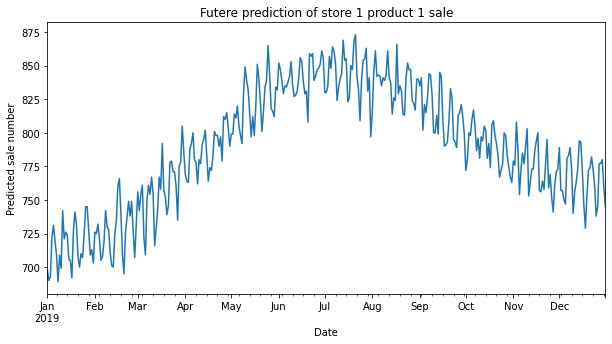

In [35]:
store = 1
product = 1 
Future_w_features.query(f'store == {store} & product == {product}')['number_sold'].plot(figsize = (10,5))
plt.ylabel('Predicted sale number')
plt.title(f'Futere prediction of store {store} product {product} sale')
plt.show()